# Project 02: Data Quality Assessment and Cleaning Pipeline
---

Dataset Source:

Clore, J., Cios, K., DeShazo, J., & Strack, B. (2014). Diabetes 130-US Hospitals for Years 1999-2008 [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5230J.

Cite: Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.

This dataset captures a decade (1999–2008) of clinical care records from 130 U.S. hospitals and integrated delivery networks. Each record represents a hospital encounter involving a patient diagnosed with diabetes who received laboratory tests, medications, and had a hospital stay of up to 14 days. The dataset’s primary objective is to predict whether a patient will be readmitted within 30 days of discharge. This problem is significant because, while strong evidence supports the benefits of preventive and therapeutic interventions for diabetic patients, many do not receive consistent care. Inadequate diabetes management in hospital settings can lead to poor glycemic control, resulting in higher hospital readmission costs and increased health risks, including greater morbidity and mortality among patients.

## Load
---
Summary:
 - Libraries Imported:
     - pandas as pd: DataFrame operations, CSV reading, data manipulation
     - numpy as np: Numeric operations, NaN handling, statistical calculations
     - warnings: Suppress non-critical warnings for cleaner output
 - DataAuditor Instantiation Process:
     - Creates DataAuditor class instance with file path 'diabetic_data.csv'
     - Initializes core attributes: raw_df=None, df=None, profiling_report={}, dqi_components={}
     - Pre-loads lookup mappings in memory:
         - admission_type_map: 8 admission types
         - discharge_map: 30 discharge dispositions
         - admission_source_map: 26 admission sources

In [1]:
# Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from auditor import DataAuditor
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataAuditor instance
auditor = DataAuditor('diabetic_data.csv')

## Data Cleaning
---
Summary:
 - Convertes admission_type_id, discharge_disposition_id, and admission_source_id to numeric, coercing invalid values to nulls.
 - Creates three new descriptive columns (admission_type_desc, discharge_disposition_desc, admission_source_desc) by mapping the ID columns to readable labels and labeling unmapped IDs as “Unknown”.
 - Replaces every "?" in the entire dataframe with a null
 - Replaces all string variants that indicate “unknown” ("Unknown", "unknown", "UNKNOWN", "Not Available", "NULL", "Not Mapped", "Unknown/Invalid") with nulls.
 - Stripes the square brackets from the weight and age band columns so values go from formats like "[0-10)" to "0-10", while keeping them as categorical bands.
 - Removes completely duplicate rows from the dataset and keep only unique records.
 - Cleaning Results:
     - Rows after cleaning: 101,766 (no data loss from duplicates - 0 removed)
     - Unique patients: 71,518 (average ~1.42 encounters per patient)
     - Pipeline success: Load → Clean → Profile → DQI all completed
 - Data Quality Index (DQI): 0.982 Excellent
     - Completeness: 0.945 (94.5% non-null values across columns)
     - Coded Consistency: 1.000 (100% valid codes in key fields gender, readmitted, admission_type_id, discharge_disposition_id, admission_source_id & time_in_hospital)
     - Duplicates: 1.000 (0% duplicate rows in raw data)

In [2]:
# Run complete pipeline: load → clean → profile → DQI.
results = auditor.run_full_audit(verbose=True)

# Access profiling report
profiling = results['profile']

# Access DQI
dqi = results['dqi_score']
dqi_components = results['dqi_components']

Removed 0 duplicate rows
Rows (cleaned): 101766
Unique patients: 71518
Baseline DQI: 0.982

DQI Components: {'completeness': 0.945, 'coded_consistency': 1.0, 'duplicates': np.float64(1.0)}


In [3]:
# Access cleaned data
df_clean = auditor.df
df_clean.head()
#df_clean.to_csv('diabetic_data_cleaned.csv', index=False)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,0-10,nan,6,25,1,1,...,No,No,No,No,No,No,NO,NaN,NaN,Physician Referral
1,149190,55629189,Caucasian,Female,10-20,nan,1,1,7,3,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,20-30,nan,1,1,7,2,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,30-40,nan,1,1,7,2,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,40-50,nan,1,1,7,1,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


## Exploratory Data Analysis (EDA)
---
Summary:
 - Dataset Overview
     - Size: 101,766 rows × 53 columns (13 numeric, 40 categorical)
     - Unique patients: 71,518 (avg 1.42 encounters/patient)
     - Data quality: Excellent structure, expected clinical missingness
 - Target Variable - Readmission Rates
     - NO: 54% (54,864 cases)
     - \>30 days: 35% (35,545 cases)
     - \<30 days: 11% (11,357 cases)
     - \>Imbalanced: 11% early readmission
 - Demographics
     - Gender: 54% Female (54,708), 46% Male (47,055) - Similar rates across genders
     - Race: 75% Caucasian (76,099), 19% AfricanAmerican (19,210), 2% Hispanic
     - Age: Elderly dominant, heavily skewed to 50+- 70-80 (26K), 60-70 (22K), 50-60 (17K), 80-90 (17K)
 - Clinical Patterns
     - Hospital stay: Right-skewed (most <5 days, some up to 14 days)
     - Admission types (Top): Emergency → Elective → Urgent
     - Age-stay correlation: Older patients tend to stay longer
     - The number of medications is positively correlated with time in the hospital (0.47) and the number of procedures (0.39)

In [4]:
# Data types, shape and basic outline
print('Diabetes Dataset EDA')
print('\nData Basic Outline:')
df_clean.info() 

Diabetes Dataset EDA

Data Basic Outline:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 53 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   encounter_id                101766 non-null  int64 
 1   patient_nbr                 101766 non-null  int64 
 2   race                        99493 non-null   object
 3   gender                      101763 non-null  object
 4   age                         101766 non-null  object
 5   weight                      101766 non-null  object
 6   admission_type_id           101766 non-null  int64 
 7   discharge_disposition_id    101766 non-null  int64 
 8   admission_source_id         101766 non-null  int64 
 9   time_in_hospital            101766 non-null  int64 
 10  payer_code                  61510 non-null   object
 11  medical_specialty           51817 non-null   object
 12  num_lab_procedures          101766 non-null 

In [5]:
# Target variable analysis
print('Readmission Rates')
readmit_dist = df_clean['readmitted'].value_counts()
readmit_pct = df_clean['readmitted'].value_counts(normalize=True) * 100

print('\nReadmission Distribution:')
print(readmit_dist)
print('\nReadmission Rates(%):')
for label, pct in readmit_pct.items():
    print(f'  {label}: {pct:.1f}%')

# Demographic review
print('\n\nDemographics:')
print(f'Gender: {profiling['gender_distribution']}')
print(f'Races: {profiling['race_distribution']}')
print(f'Age distribution preview: {dict(list(profiling['age_groups'].items())[:5])}')

# Missing data
print('\nMissing Data (% of rows)')
missing_pct = (df_clean.isna().sum() / len(df_clean) * 100).round(1)
missing_top = missing_pct.nlargest(5)
print(missing_top)

Readmission Rates

Readmission Distribution:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Readmission Rates(%):
  NO: 53.9%
  >30: 34.9%
  <30: 11.2%


Demographics:
Gender: {'Female': 54708, 'Male': 47055, nan: 3}
Races: {'Caucasian': 76099, 'AfricanAmerican': 19210, nan: 2273, 'Hispanic': 2037, 'Other': 1506, 'Asian': 641}
Age distribution preview: {'70-80': 26068, '60-70': 22483, '50-60': 17256, '80-90': 17197, '40-50': 9685}

Missing Data (% of rows)
max_glu_serum          94.7
A1Cresult              83.3
medical_specialty      49.1
payer_code             39.6
admission_type_desc    10.2
dtype: float64


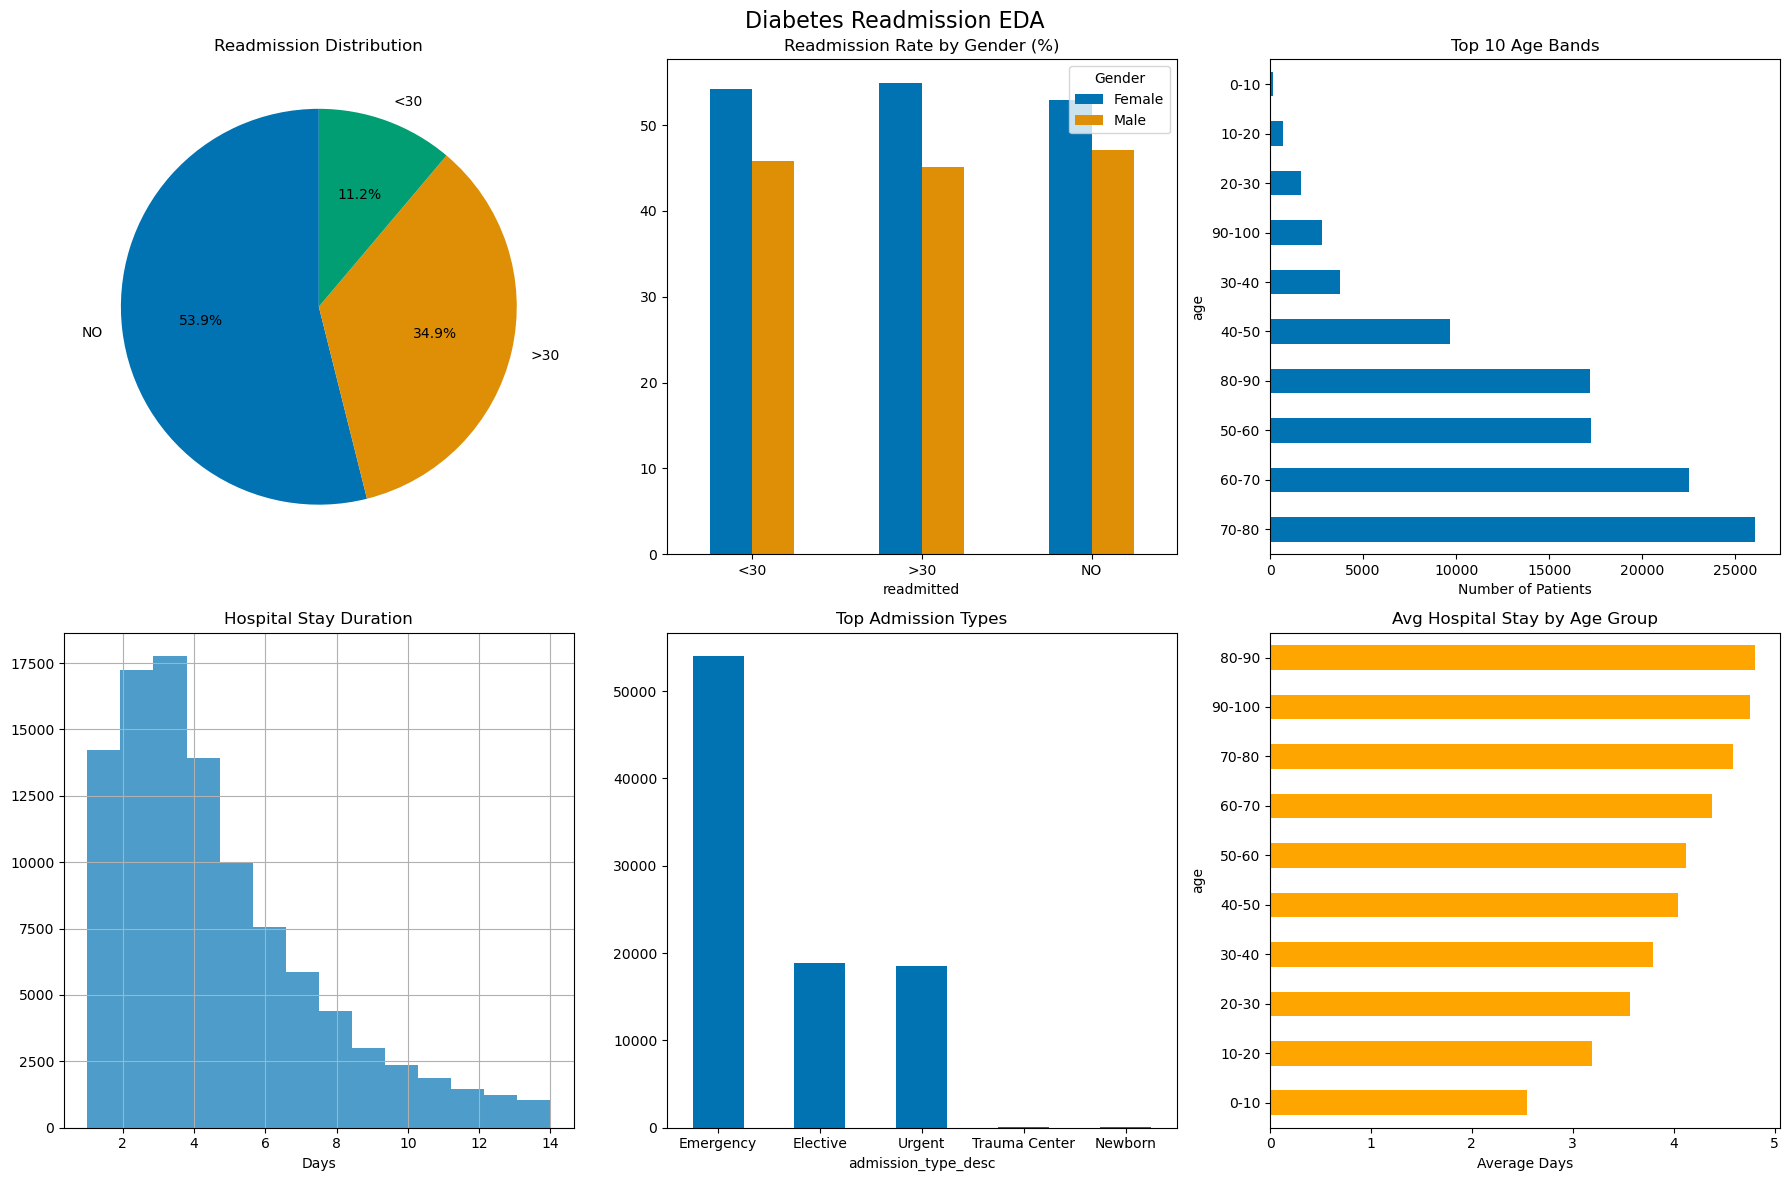

In [6]:
# Set style for plots
plt.style.use('default')
sns.set_palette('colorblind')
%matplotlib inline

# Visualization grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Diabetes Readmission EDA', fontsize=16)

# Readmission pie chart
axes[0,0].pie(readmit_dist.values, labels=readmit_dist.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Readmission Distribution')

# Gender vs Readmission bar chart
readmit_gender = pd.crosstab(df_clean['readmitted'], df_clean['gender'], normalize='index') * 100
readmit_gender.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Readmission Rate by Gender (%)')
axes[0,1].legend(title='Gender')
axes[0,1].tick_params(axis='x', rotation=0)

# Age bands distribution horizonal bar chart
df_clean['age'].value_counts().head(10).plot(kind='barh', ax=axes[0,2])
axes[0,2].set_title('Top 10 Age Bands')
axes[0,2].set_xlabel('Number of Patients')

# Time in hospital distribution histogram
df_clean['time_in_hospital'].hist(bins=14, ax=axes[1,0], alpha=0.7)
axes[1,0].set_title('Hospital Stay Duration')
axes[1,0].set_xlabel('Days')

# Admission type bar chart 
df_clean['admission_type_desc'].value_counts().head(7).plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Top Admission Types')
axes[1,1].tick_params(axis='x', rotation=0)

# Average days stayed by age group horizonal bar chart
age_stay = df_clean.groupby('age')['time_in_hospital'].mean().sort_values(ascending=True).head(10)
age_stay.plot(kind='barh', ax=axes[1,2], color='orange')
axes[1,2].set_title('Avg Hospital Stay by Age Group')
axes[1,2].set_xlabel('Average Days')
axes[1,2].tick_params(axis='y', labelrotation=0)

plt.tight_layout()
plt.show()

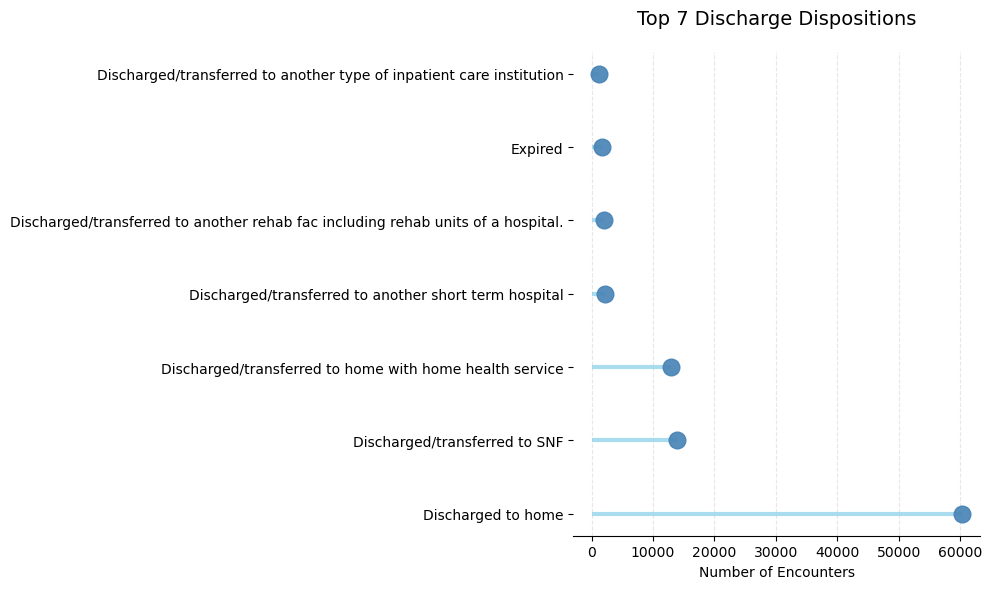

In [7]:
# Discharge disposition
discharge_top = df_clean['discharge_disposition_desc'].value_counts().head(7)

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Horizontal lollipop
y_pos = np.arange(len(discharge_top))
ax.hlines(y_pos, 0, discharge_top.values, colors='skyblue', linewidth=3, alpha=0.7)
ax.plot(discharge_top.values, y_pos, 'o', markersize=12, color='steelblue', alpha=0.9)
ax.set_yticks(y_pos)
ax.set_yticklabels(discharge_top.index)
ax.set_xlabel('Number of Encounters')
ax.set_title('Top 7 Discharge Dispositions', fontsize=14, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

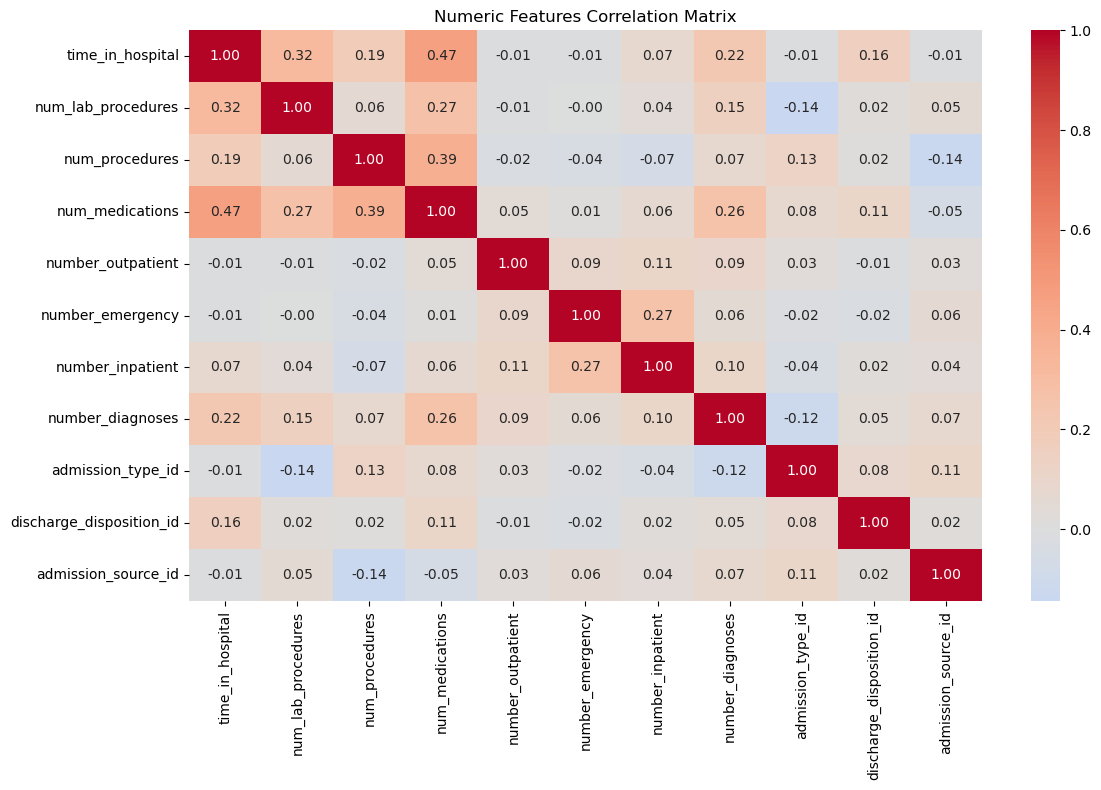

In [8]:
numeric_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
                'admission_type_id', 'discharge_disposition_id', 'admission_source_id']

# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df_clean[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Numeric Features Correlation Matrix')
plt.tight_layout()
plt.show()

## Encoding Categorical Features
---
Summary:
 - 7 new features:
     - readmit_30days
         - Binary: 1 = readmitted <30 days, 0 = others
     - age_numeric
         - Age band → numeric midpoint (5, 15, 25, ..., 95)
         - Maps: '0-10':5, '10-20':15, ..., '90-100':95
     - med_count
         - score: counts active diabetes medications (0-23)
         - Counts "Up"/"Steady"/"Down" across 23 med columns
         - Higher values indicate complex diabetes management
     - utilization_score
         - Weighted prior healthcare utilization
         - Formula: (0.2×outpatient) + (0.5×emergency) + (1.0×inpatient)
         - Captures patient acuity and healthcare system interaction     
     - diabetes_med
         - Binary diabetes medication flag: 1 = Yes (any diabetes med), 0 = No
     - female
         - Binary gender flag: 1 = Female, 0 = Male
     - diag_severity
         - Categorical comorbidity burden based on number_diagnoses
         - Bins: Low (0-3 diagnoses), Medium (4-6), High (7-9), Very High (10+)

In [9]:
# Create a binary target
df_clean['readmit_30days'] = (df_clean['readmitted'] == '<30').astype(int)

# Age band to midpoint number
age_map = {
    '0-10': 5, '10-20': 15, '20-30': 25, '30-40': 35, '40-50': 45,
    '50-60': 55, '60-70': 65, '70-80': 75, '80-90': 85, '90-100': 95
}
df_clean['age_numeric'] = df_clean['age'].map(age_map)

# Medication score
med_cols = [col for col in df_clean.columns if col in [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglinide',
    'metformin-pioglitazone']]

# Count "Up"/"Steady"/"Down" (active meds) vs "No"
df_clean['med_count'] = df_clean[med_cols].apply(
    lambda row: sum(1 for x in row if x in ['Up', 'Steady', 'Down']), axis=1)

df_clean['diabetes_med'] = df_clean['diabetesMed'].map({'Yes': 1, 'No': 0})

# Utilization score
df_clean['utilization_score'] = (
    df_clean['number_outpatient'] * 0.2 +
    df_clean['number_emergency'] * 0.5 +
    df_clean['number_inpatient'] * 1.0)

# Genter to binary
df_clean['female'] = (df_clean['gender'] == 'Female').astype(int)

# Number of diagnoses to bins
df_clean['diag_severity'] = pd.cut(
    df_clean['number_diagnoses'], 
    bins=[0, 3, 6, 9, 16], 
    labels=['Low', 'Medium', 'High', 'Very High'])

df_clean.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,admission_type_desc,discharge_disposition_desc,admission_source_desc,readmit_30days,age_numeric,med_count,diabetes_med,utilization_score,female,diag_severity
0,2278392,8222157,Caucasian,Female,0-10,nan,6,25,1,1,...,NaN,NaN,Physician Referral,0,5,0,0,0.0,1,Low
1,149190,55629189,Caucasian,Female,10-20,nan,1,1,7,3,...,Emergency,Discharged to home,Emergency Room,0,15,1,1,0.0,1,High
2,64410,86047875,AfricanAmerican,Female,20-30,nan,1,1,7,2,...,Emergency,Discharged to home,Emergency Room,0,25,1,1,1.4,1,Medium
3,500364,82442376,Caucasian,Male,30-40,nan,1,1,7,2,...,Emergency,Discharged to home,Emergency Room,0,35,1,1,0.0,0,High
4,16680,42519267,Caucasian,Male,40-50,nan,1,1,7,1,...,Emergency,Discharged to home,Emergency Room,0,45,2,1,0.0,0,Medium
